In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
import sklearn
import sqlite3
import matplotlib

import numpy as np
import pandas as pd
import enchant as en
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_validation import train_test_split, cross_val_score, KFold
from sklearn.linear_model import Ridge

src_dir = os.path.join(os.getcwd(), os.pardir, 'src')
sys.path.append(src_dir)
%aimport data
from data import make_dataset as md

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (16.0, 6.0)
plt.rcParams['legend.markerscale'] = 3
matplotlib.rcParams['font.size'] = 16.0

/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Data: Preparing for the model

#### Importing the raw data

In [2]:
DIR = os.getcwd() + "/../data/"
t = pd.read_csv(DIR + 'raw/loan.csv', low_memory=False)
t.head(3)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000,5000,4975,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Cleaning, imputing missing values, feature engineering (some NLP)

In [3]:
t2 = md.clean_data(t)
t3 = md.impute_missing(t2)
df = md.simple_dataset(t3)

Now cleaning data.
Now imputing missing values and encoding categories.
Skipping NLP/geo stuff, and removing cols.


/usr/local/lib/python2.7/site-packages/pandas/core/frame.py:2705: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


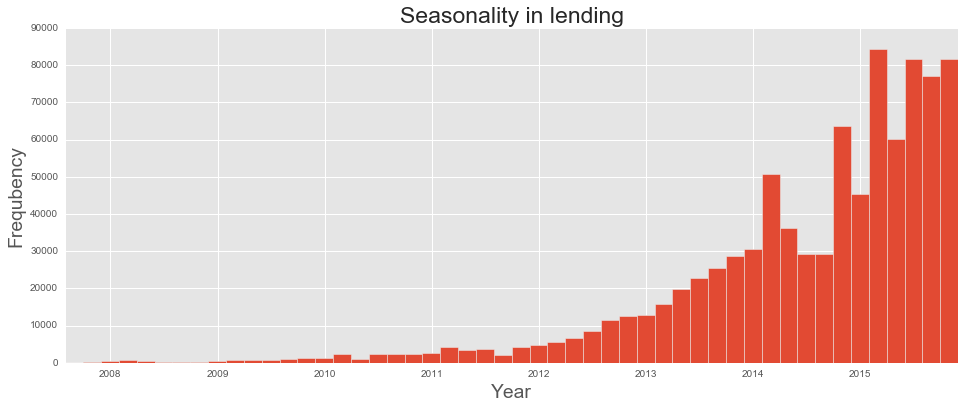

In [4]:
df['issue_d'].hist(bins = 50)
plt.title('Seasonality in lending')
plt.ylabel('Frequbency')
plt.xlabel('Year')
plt.show()

## Fitting the model

In [5]:
X = df.drop(['int_rate', 'issue_d', 'earliest_cr_line', 'grade'], 1)
y = df['int_rate']
X.shape, y.shape

((884766, 79), (884766,))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((592793, 79), (291973, 79), (592793,), (291973,))

### Ridge

In [7]:
scores_ridge = list()
scores_std_ridge = list()

ridge = Ridge()
coefs = []
errors = []

alphas = np.logspace(-6, 6, 20)

# Train the model with different regularisation strengths
for a in alphas:
    ridge.set_params(alpha=a)
    this_scores = cross_val_score(ridge, X_train, y_train, cv=3, n_jobs=1)
    scores_ridge.append(np.mean(this_scores))
    scores_std_ridge.append(np.std(this_scores))
    

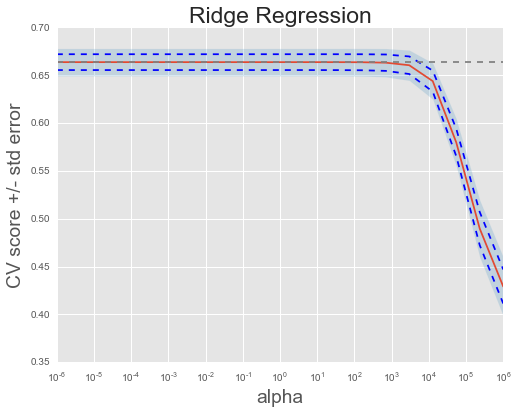

In [8]:
scores_ridge, scores_std_ridge = np.array(scores_ridge), np.array(scores_std_ridge)

plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, scores_ridge)

# plot error lines showing +/- std. errors of the scores
std_error = scores_std_ridge / np.sqrt(3)

plt.semilogx(alphas, scores_ridge + std_error, 'b--')
plt.semilogx(alphas, scores_ridge - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, scores_ridge + scores_std_ridge, scores_ridge - scores_std_ridge, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.title('Ridge Regression')
plt.axhline(np.max(scores_ridge), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])

plt.show()

In [10]:
ridge = Ridge(alpha=10**0)
ridge.fit(X_train, y_train)
ridge.score(X_test, y_test)
print("CV Accuracy: {:.2f}".format(np.max(scores_ridge)))
print("Test Accuracy: {:.2f}".format(ridge.score(X_test, y_test)))

CV Accuracy: 0.66
Test Accuracy: 0.67


### Random Forest Regressor

In [11]:
rfr = RandomForestRegressor(n_estimators = 10, max_features='sqrt')
total_scores = cross_val_score(rfr, X_train, y_train, cv = 3)

print("CV Accuracy: {:.2f} (+/- {:.2f})".format(total_scores.mean(), total_scores.std() * 2))

CV Accuracy: 0.79 (+/- 0.01)


In [12]:
rfr.fit(X_train, y_train)
print("Test Accuracy: {:.2f}".format(rfr.score(X_test, y_test)))

Test Accuracy: 0.83


In [14]:
fi = [{'importance': x, 'feature': y} for (x, y) in \
      sorted(zip(rfr.feature_importances_, X.columns))]
fi = pd.DataFrame(fi)
fi.sort_values(by = 'importance', ascending = False, inplace = True) 
fi.head()

,feature,importance
78,total_rec_int,0.152524
77,term_ 36 months,0.088441
76,installment,0.075740
75,last_pymnt_amnt,0.054784
74,total_rec_prncp,0.054069


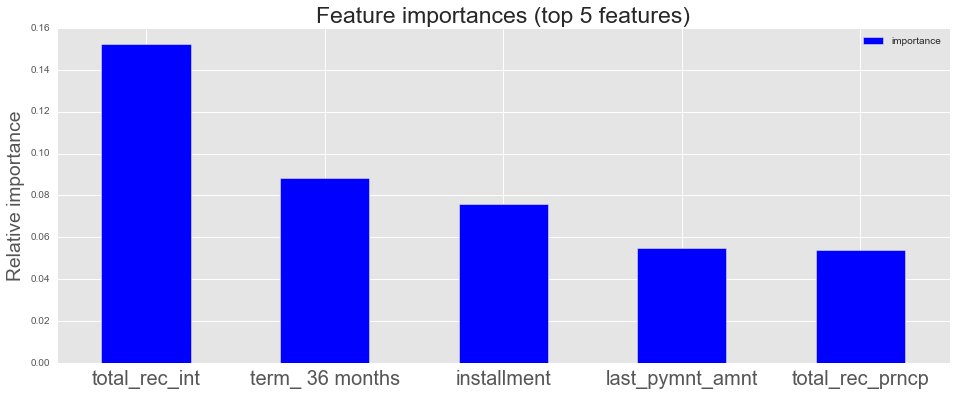

In [15]:
top5 = fi.head()
top5.plot(kind = 'bar')
plt.xticks(range(5), top5['feature'], fontsize=20,rotation=0)
plt.title('Feature importances (top 5 features)')
plt.ylabel('Relative importance')
plt.show()

### Ada Boost Regressor

In [16]:
ada = AdaBoostRegressor(DecisionTreeRegressor(max_depth=2),
                          n_estimators=300, random_state=0)
total_scores = cross_val_score(ada, X_train, y_train, cv = 3)
total_scores = cross_val_score(rfr, X_train, y_train, cv = 3)
ada.fit(X_train, y_train)
print("CV Accuracy: {:.2f} (+/- {:.2f})".format(total_scores.mean(), total_scores.std() * 2))
print("Test Accuracy: {:.2f}".format(ada.score(X_test, y_test)))

CV Accuracy: 0.81 (+/- 0.01)
Test Accuracy: 0.28
